## Hashing the human transcriptome

2024-2025

Alan M H Beem

In [7]:
# setup
import matplotlib.pyplot as plt
from random import SystemRandom
from ht_adts import HashTableIncrement
import math
from ht_algorithms import get_dicts_from_files


n_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Data structures:

##### (HT1) Hash table - (key: str, value: int =1); update behavior: increments by value

##### (HT2) Hash table - (key: str, value: list[int]); update behavior: appends value to list, used in ht_methods.py

<!-- ##### (HT3) Hash table - (key: str, value: hashable); update behavior: add value to set -->

For visualization along a single sequence:

##### (λ) 2D List - |n_list| × |sequence|

Constants:

(N) List = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

(cD) dict = {'A':'U', 'U':'A', 'G':'C', 'C':'G'}

#### Data:

      RNA sequences: {A, U ≡ T, G, C}  (T is replaced with U, where applicable)

      (a) Human RNA transcript sequences ⟵ Human GENCODE v46
      (b) Human 3'UTR RNA sequences ⟵ Human GENCODE v46
      (c) random sequences ⟵ f(RANDOM.ORG text file {'0', '1'})
            (1) length = 1214
            (2) lengths = length of each 3'-UTR if present
            (3) lengths = length of each transcript
      (d) pseudorandom RNA sequences with higher probability of being related ⟵ RegSeqGenerator

      (e) Human (hsa) miRNA seed sequences ⟵ miRBase release __
      (f) possible 6nt seed sequences ⟵ all_seq(N=6)


##### Algorithm 1:
$Let$ $data ∈ \{a, b, c, d\},$ $let$ $transcript ∈ data:$

$For$ $each$ $N = [1, 12] nt$ $subsequence$ $of$ $transcript: (HT1).add(subsequence: str)$

O(N) for N = number of nucleotides

##### Algorithm 3: For visualization across a given sequence
$Let$ $sequence = \{A, U, G, C\}$<sup>k</sup>

$λ⟵[$ $[$ $]$ $for$ $N = 1$ $to$ $12]$

$For$ $each$ $N = [1, 12] nt$ $subsequence$ $of$ $sequence: λ[N].append((HT1).get(subsequence): int)$

O(N) for N = len(sequence) = k

In [2]:
# Brute force alternative, for each of all sequences: for each transcript: for each subsequence: SeqUtils.nt_search()

#### Algorithm 1 and Algorithm 3 applied to data:
If these cells were ordered by the order written, then this would be after some of the cells that follow.

From the terminal, the command 'python3 ht_algorithms.py' was executed, applying Algorithm 1 to (a) (b) (c), the runtime was greater than 1 hour.

In [191]:
labels, count_data = get_dicts_from_files()  # a runtime: 50.8s
transcripts = [r.strip() for r in open('count_data/transcripts.txt', 'r').readlines()]  # a runtime: 0.4s
utr3s = [r.strip().split(',')[1] for r in open('count_data/utr3s_length_sequence.txt', 'r').readlines()]
print('labels:', labels)
print(f"len(count_data): {len(count_data)}")
print(f"lengths of count_data: {' '.join(str(len(count_data[i])) for i in range(len(count_data)))}")

labels: ['transcripts', 'utr3s', 'r100', 'r1k', 'r10k']
len(count_data): 5
lengths of count_data): 12 12 12 12 12


selected transcript sequence length: 559
      N:  1	2 	3 	4  	5   	6   	7    	8    	9     	10     	11     	12      
    4^N:  4	16	64	256	1024	4096	16384	65536	262144	1048576	4194304	16777216
subseqs:  4	16	63	192	373	477	517	535	540	541	542	542


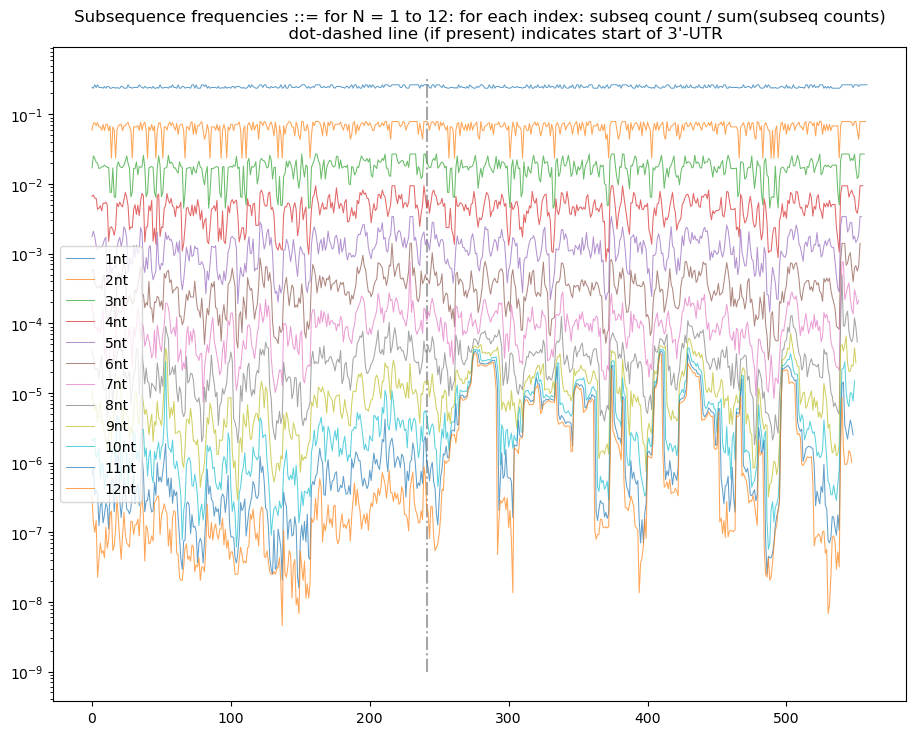

In [188]:
rna_seq_counts = [HashTableIncrement() for _ in n_list]
rna_seq_subseq_counts = [[] for _ in n_list]
selector_int = SystemRandom().randrange(0, len(transcripts))
rna_sequence = transcripts[selector_int]
utr3 = utr3s[selector_int]
# if len(utr3) > 0:
#     rna_sequence += 'A' * 100  # can assume a poly-A tail, but of unknown utility
print(f"selected transcript sequence length: {len(rna_sequence)}")

# Algorithm 1 applied to the selected sequence
# this shows the number of distinct subsequences in the sequence
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_counts[n - 1].add(rna_sequence[i:i + n])

# How many subsequences were observed, for each N ?
print(f"      N:  {'\t'.join([str(n).ljust(int(math.log10(4**n) + 1)) for n in n_list])}")
print(f"    4^N:  {'\t'.join([str(4**n) for n in n_list])}")
print(f"subseqs:  {'\t'.join([str(len(r)) for r in rna_seq_counts])}")
# Where these numbers 'join up' with decrementing number of total subseq windows
# is a function of N, but what is the slope? Compare to natural sequences TODO

# Algorithm 3
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_subseq_counts[n - 1].append(count_data[0][n - 1].get(rna_sequence[i:i + n]))

# normalization factor is sum of observations of all N nt subsequences, for N = 1 to 12
norm_factors = [sum(count_data[0][i].values()) for i in range(len(count_data[0]))]

fig = plt.figure()
plt.title("""Subsequence frequencies ::= for N = 1 to 12: for each index: subseq count / sum(subseq counts)
          dot-dashed line (if present) indicates start of 3'-UTR""")
plt.xlabel('nt (indexed from 0)')  # the standard is to index from 1, but, for convenience I am indexing from 0
fig.set_size_inches(11,8.5)
if len(utr3) > 0:
    plt.vlines([len(rna_sequence) - len(utr3)], ymin=[10**-9], ymax=[0.35], linestyles='-.', colors=['k'], alpha=0.35)
for n in n_list:
    plt.plot([c / norm_factors[n - 1] for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.7, linewidth=0.75)
    # plt.plot([1 / c for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.3)  # this flips it upside down, showing the infrequency of subseqs
plt.yscale('log')
plt.legend(loc='center left')
plt.show()

# this is but one numerical property of sequences as such, for particular applications, other stuff might be useful

#### Algorithm 1 and Algorithm 3 applied to a single sequence:

Generated sequence:
 AGAUGUGGAGGCCGAUUUAACCACACUCCCCAGUCUGGGUGUAUCGCUCUGCCGGUUCCUGAAGGGCCUGUCCCCACGAAUGGGAACCACUGGCCUGGCUGAGAGCACUCCUGCCCCAAUGUGUCGUUACGAGAUAGUCUGCGCAUCACCGUCUAUUAUAUCUUCGACUGUCCAGCGUCGCCGCAUUUCUGUUGUUAGUCAUGAUGCGCCUUGUGGUUUGUAAGAGCCGCUCUCUACCUUCGCCGUCUCUCGAGUGCAUCACAAUUCAGGGCGCAUGCCGCGGACAAAUUGAUCUUCCGAUUCCAACUUCGUCCGACUGUUACACGAGGUACCGCGACUAAGAGCAGAGGUACGAGCUUGCGGCCCCGUCAUGAACUCAGUAUGACCACCCACUCUCACUCGAAAGCACGGGAUUGUUCCAGAUAUGCAAGAGCUAUAACUCGAACCGCUCGGGGUGGAUAAUGCCCCGAGGAAAGGGUAUGUUCUUAAUGGUUUCUAGACCCUCGUAAAAAUUUCACGUAGUGACUAGCUCCUCUGGACUAGACAUAGCCAGCCCUAAUAUUGUUUACAUUCCUCUUGGAUAUUUACAGAGGUACGCGUACGAUUUACUCCGGGUUGCUAGUUGCGGGGCCAGAUUGAUGGAAAUUACAAUCAUCCCCAUUCACCUGUUGCCCCUCCCAAUUUCACUUUGGCAGGGAGCACCUAGAUGUACCCGCUGGACCCGCUAGACACAUCUGAUCCAGCCUUUCCCUAUGAGUUUACGAAUGCGAGAACUCUUGUGUGGUCCGUUACGCUCUCUCGCCUGUCCAACCACGUUUUCCUUGGUCAGUGUCUAUCACUGCUCUAGGAAUCCUGCAUGUGUACAAAUCUGCGCGACGCAAGAUGUCGCUGGUCGGGCCUAUUACUACGGGGCUUCAGGAAGUCCAUACAUCGCAAAGAACCUGGGGCUUUUGGGUUUUCUCGUUGACAAUUUGGCUAC

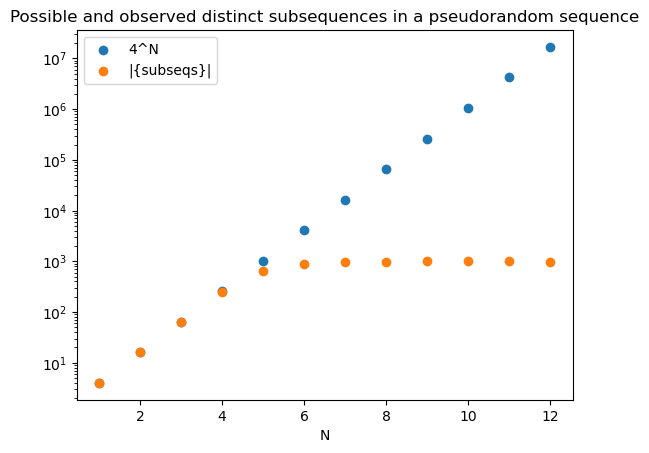

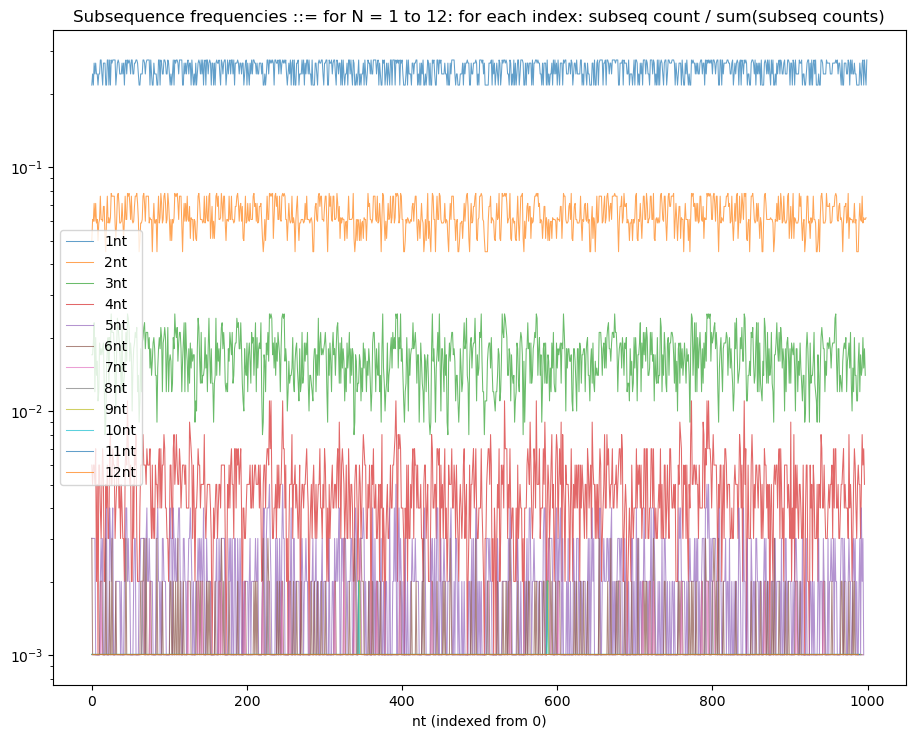

In [202]:
n_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

rna_seq_counts = [HashTableIncrement() for _ in n_list]
rna_seq_subseq_counts = [[] for _ in n_list]
rna_sequence = ''.join(SystemRandom().choices(['A', 'U', 'G', 'C'], k=1000))
print('Generated sequence:\n', rna_sequence)

# Algorithm 1
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_counts[n - 1].add(rna_sequence[i:i + n])

# How many subsequences were observed, for each N ?
print(f"      N:\t{'\t\t'.join([str(n) for n in n_list])}")
print(f"    4^N:\t{'\t\t'.join([str(4**n) for n in n_list])}")
print(f"subseqs:\t{'\t\t'.join([str(len(r)) for r in rna_seq_counts])}")
# Where these numbers 'join up' with decrementing number of total subseq windows
# is a function of N, but what is the slope? when does the decrease start? For a pseudorandom sequence it seems significant by 7nt

plt.figure()
plt.scatter([n for n in n_list], [4**n for n in n_list], label='4^N')
plt.scatter([n for n in n_list], [len(r) for r in rna_seq_counts], label='|{subseqs}|')
plt.xlabel('N')
plt.title('Possible and observed distinct subsequences in a pseudorandom sequence')  # TODO add gene name
plt.yscale('log')
plt.legend()
plt.show()

# normalization factor is sum of observations of all N nt subsequences, for N = 1 to 12
norm_factors = [sum(rna_seq_counts[i].values()) for i in range(len(rna_seq_counts))]

# Algorithm 3
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_subseq_counts[n - 1].append(rna_seq_counts[n - 1].get(rna_sequence[i:i + n]))

fig = plt.figure()
plt.title("""Subsequence frequencies ::= for N = 1 to 12: for each index: subseq count / sum(subseq counts)""")
plt.xlabel('nt (indexed from 0)')  # the standard is to index from 1, but, for convenience I am indexing from 0
fig.set_size_inches(11,8.5)
for n in n_list:
    plt.plot([c / norm_factors[n - 1] for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.7, linewidth=0.75)
    # plt.plot([1 / c for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.3)  # this flips it upside down, showing the infrequency of subseqs
plt.yscale('log')
plt.legend(loc='center left')
plt.show()



Selected sequence:
 CCCAGUGUCUGACUCUGCAGGGCCCUAGUGGUAUAAAGGUACUGAGACUUGCCUGUGUUCAGGGCUUCCUGAAGAUUAAAUGGCUGCCGAAGUUCUUGAGUUUAGCUUUAGCUCAAAAGAUACUGCGUCAGACUCUGCGUUCUGAGUAGAGUCUCAGAGAAUGAAAAAAGAAAUACAAUGAAAAAGGGGAAAACUUCAAUCCAGAACCUCUUACCACAGUUUCUGGUAGAAUGCUGGCAAUUUCCAGGAAGAUACGUGGAGAACGGAAAGGUUGCUACACCCAAAUAGUGAAGCAAAGGCUAUGAUUAUGGAGGAUUGGACCUGCAAACUCCAGAACAGAGUUCUGCCCUCUGAGGACCCUGCCCUUUCCCAAAAGGGGUAUCUUAAGAAGGAAAAUAUGGCUGCUCUUUGCCGGACAGCAGAGUCCCAGAACCCCAUGCAGGUGUUUCAGGGCUUUAUGUCAUUCAAGGAUGUGGCUGUGAACUUCACUAGGAAGAAUGGAGAGAACUGGACCUUGCUCAGAGAGUCUUGUACAGGGAUGUAAUGCUGGAGAACUAUAGGAACCUGGUCUCCUUGGGAUU
      N:	1		2		3		4		5		6		7		8		9		10		11		12
    4^N:	4		16		64		256		1024		4096		16384		65536		262144		1048576		4194304		16777216
subseqs:	4		16		62		205		391		502		544		561		570		571		571		570


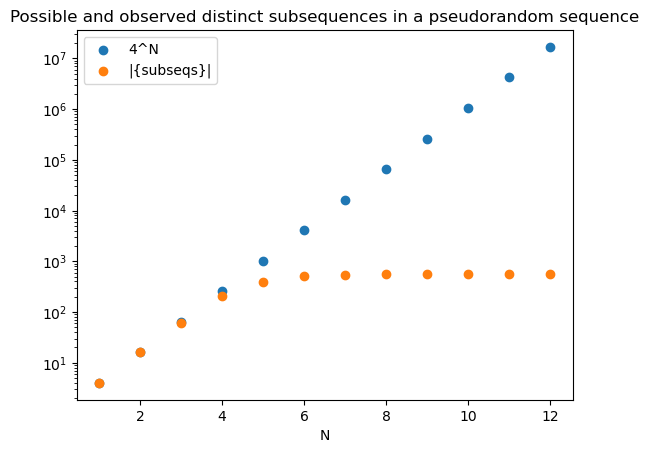

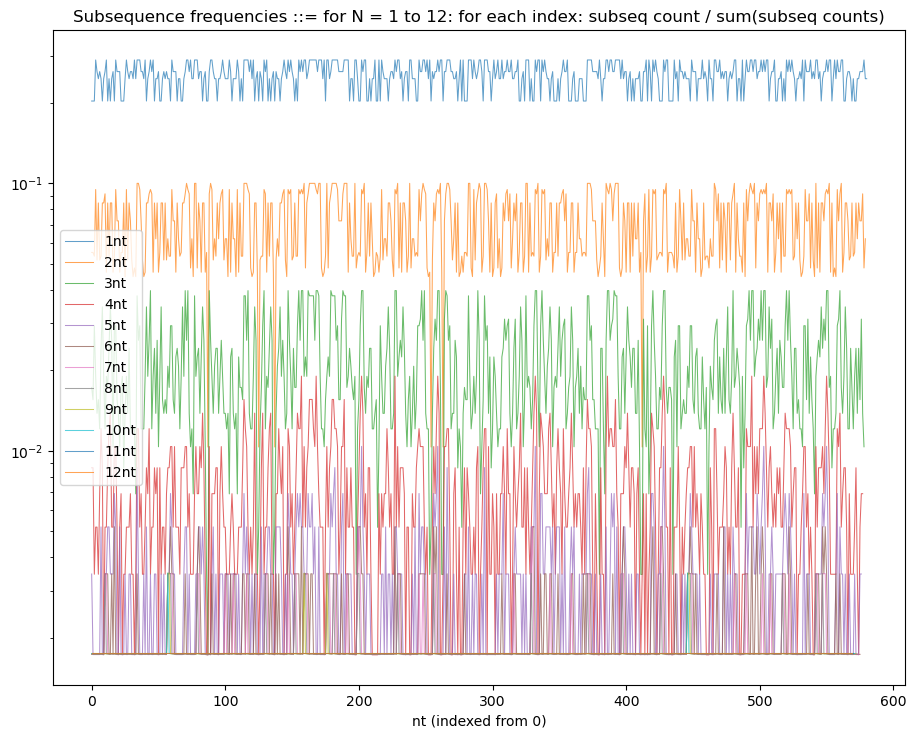

In [201]:
n_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

rna_seq_counts = [HashTableIncrement() for _ in n_list]
rna_seq_subseq_counts = [[] for _ in n_list]
selector_int = SystemRandom().randrange(0, len(transcripts))
rna_sequence = transcripts[selector_int]
print('Selected sequence:\n', rna_sequence)

# Algorithm 1
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_counts[n - 1].add(rna_sequence[i:i + n])

# How many subsequences were observed, for each N ?
print(f"      N:\t{'\t\t'.join([str(n) for n in n_list])}")
print(f"    4^N:\t{'\t\t'.join([str(4**n) for n in n_list])}")
print(f"subseqs:\t{'\t\t'.join([str(len(r)) for r in rna_seq_counts])}")
# Where these numbers 'join up' with decrementing number of total subseq windows
# is a function of N, but what is the slope? when does the decrease start? For a pseudorandom sequence it seems significant by 7nt

plt.figure()
plt.scatter([n for n in n_list], [4**n for n in n_list], label='4^N')
plt.scatter([n for n in n_list], [len(r) for r in rna_seq_counts], label='|{subseqs}|')
plt.xlabel('N')
plt.title('Possible and observed distinct subsequences in a pseudorandom sequence')  # TODO add gene name
plt.yscale('log')
plt.legend()
plt.show()

# normalization factor is sum of observations of all N nt subsequences, for N = 1 to 12
norm_factors = [sum(rna_seq_counts[i].values()) for i in range(len(rna_seq_counts))]

# Algorithm 3
for i in range(len(rna_sequence)):
    for n in n_list:
        if i + n <= len(rna_sequence):
            rna_seq_subseq_counts[n - 1].append(rna_seq_counts[n - 1].get(rna_sequence[i:i + n]))

fig = plt.figure()
plt.title("""Subsequence frequencies ::= for N = 1 to 12: for each index: subseq count / sum(subseq counts)""")
plt.xlabel('nt (indexed from 0)')  # the standard is to index from 1, but, for convenience I am indexing from 0
fig.set_size_inches(11,8.5)
for n in n_list:
    plt.plot([c / norm_factors[n - 1] for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.7, linewidth=0.75)
    # plt.plot([1 / c for c in rna_seq_subseq_counts[n - 1]], label=f"{n}nt", alpha=0.3)  # this flips it upside down, showing the infrequency of subseqs
plt.yscale('log')
plt.legend(loc='center left')
plt.show()



#### Using class RegSeqGenerator to generate synthetic sequences
This class is constructed with a "master sequence" which is pseudorandomly walked, with some other parameters, with the thought of making sequences with a greater degree of similarity, but it's more of a brainstorm than a designed piece of code (from summer project on Boolean networks, abundances, and miRNAs).

TODO

### Data formats:

#### APPENDIX

I also tried writing down all the locations of every subsequence over all transcripts, 3' UTRs, and (c)(1) random sequences. Adding to a list or string seemed to run indefinitely, but not halt- maybe it was still going. I tried writing directly to millions of files, and that worked, with a runtime between 1 and 2 days.


##### Algorithm for locations:  
$Let$ $data ∈ \{a, b, c, d\},$ $let$ $transcript ∈ data:$

$For$ $each$ $N = [1, 12] nt$ $subsequence$ $of$ $transcript: write to /{N}nt/{subsequence}.txt: location: (int, int)$

O(N) for N = number of nucleotides, but, practically, much slower than Algorithm 1
